## Integrating a simple harmonic oscillator and trying to infer the spring constant

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path[:]
sys.path.insert(0, '/mnt/home/landerson/.local/lib/python3.6/site-packages')
sys.path[:]
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import scipy.optimize as so
%matplotlib inline

import numpy as np   
import tensorflow as tf

import leapfrog as lf
from tensorflow.python.ops import gradients_impl

import theano
print(theano.__file__)
import theano.tensor as tt

import pymc3 as pm



session = tf.get_default_session()
if session is None:
    session = tf.InteractiveSession()

/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/mnt/home/landerson/.local/lib/python3.6/site-packages/theano/__init__.py


In [3]:
sys.path

['/mnt/home/landerson/.local/lib/python3.6/site-packages',
 '',
 '/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python36.zip',
 '/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6',
 '/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/lib-dynload',
 '/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages',
 '/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/IPython/extensions',
 '/mnt/home/landerson/.ipython']

In [4]:
tf.VERSION

'1.10.1'

In [5]:
def genData(x, v, npoints, std_noise_x, std_noise_v):
    noise_x = np.random.normal(0, std_noise_x, len(x))
    noise_v = np.random.normal(0, std_noise_v, len(x))
    return noise_x + x, noise_v + v

def tf_log_like(x0, v0, k, t_obs, step_size, data):
    chi2 = 0
    x_obs, v_obs, sigma_x, sigma_v = data
    x, v = lf.leapfrog(x0, v0, k, t_obs, step_size)
    chi2 += -(v - v_obs)**2 / sigma_v**2 - 2*np.log(sigma_v)
    chi2 += -(x - x_obs)**2 / sigma_x**2 - 2*np.log(sigma_x)
    return 0.5*tf.reduce_sum(chi2)

In [6]:
np.random.seed(1)

## Set some true values and initial guesses

In [7]:
#define true parameter values we will add noise to later
x0_true   = np.float64(10.)
v0_true   = np.float64(10.)
k_true    = np.float64(3.)

#define step size of each leap and number of shos
s_size = np.float64(0.01)      #resolution of each leap
n_shos = 1            #number of simple harmonic oscillators 

#define true observed times
max_time  = np.float64(10.)
nobspoints = 10
t_obs_true = np.random.uniform(0, max_time, nobspoints)
t_obs_true.sort()
t_compare = np.linspace(0, max_time, 1000)
#define noise properties 
std_noise_x = 1.0
std_noise_v = 1.0

In [8]:
k_guess = k_true  + np.random.normal(0, k_true)
x0_guess = x0_true + np.random.normal(0, std_noise_x)
v0_guess = v0_true + np.random.normal(0, std_noise_v)
t0_guess = t_obs_true #+ np.random.normal(0, 1., len(t_obs_true))
t0_guess.sort()

## Generate fake data and model predictions

In [9]:
#generate true values and noisify them
x0_tf    = tf.Variable(tf.constant(x0_true), name = "x0", dtype=np.float64)
v0_tf    = tf.Variable(tf.constant(v0_true), name = "v0", dtype=np.float64)
k_tf     = tf.Variable(tf.constant(k_true),  name = "k",  dtype=np.float64)
t_obs_tf = tf.Variable(tf.constant(t_obs_true), name = "t_obs",  dtype=np.float64)    
t_compare_tf = tf.Variable(tf.constant(t_compare), name='t_compare', dtype=np.float64)

session.run(tf.global_variables_initializer())

pred = lf.leapfrog(x0_tf, v0_tf, k_tf, t_compare, s_size)
xcompare, vcompare = session.run(pred)

model = lf.leapfrog(x0_tf, v0_tf, k_tf, t_obs_tf, s_size)
x_true, v_true = session.run(model)

x_obs, v_obs = genData(x_true, v_true, nobspoints, std_noise_x, std_noise_v)

In [10]:
pred

(<tf.Tensor 'leapfrog/leapfrog//xvalues/leapfrog//xvalues:0' shape=(?,) dtype=float64>,
 <tf.Tensor 'leapfrog/leapfrog//vvalues/leapfrog//vvalues:0' shape=(?,) dtype=float64>)

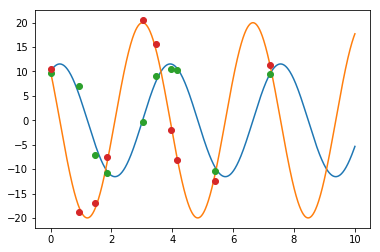

In [11]:
plt.plot(t_compare, xcompare)
plt.plot(t_compare, vcompare)
plt.plot(t_obs_true, x_obs, 'o')
plt.plot(t_obs_true, v_obs, 'o')

## Now try with TensorFlow
## Define Tensorflow variables and Tensorflow models

In [12]:
#define log likelihood model
#ll = tf_log_like(x, v, x_obs_tf, v_obs_tf, std_noise_x_tf, std_noise_v_tf)
#tf.reset_default_graph()

data = [x_obs, v_obs, std_noise_x, std_noise_v]

#turn initial parameter guesses into tensorflow tensors so tensorflow can take gradients of them
x0_tf    = tf.Variable(tf.constant(x0_guess), name = "x0"   , dtype=np.float64)
v0_tf    = tf.Variable(tf.constant(v0_guess), name = "v0"   , dtype=np.float64)
k_tf     = tf.Variable(tf.constant(k_guess),  name = "k"    , dtype=np.float64)
t_obs_tf = tf.Variable(tf.constant(t0_guess), name = "t_obs", dtype=np.float64)    

#define tensorflow models
#returns the modeled x and v values 
#model = lf.leapfrog(x0_tf, v0_tf, k_tf, t_obs_tf, s_size)
#returns the negative log likelihood of the parameters
nll = -tf_log_like(x0_tf, v0_tf, k_tf, t_obs_tf, s_size, data)

#returns the likelihood of the parameters
ll = tf_log_like(x0_tf, v0_tf, k_tf, t_obs_tf, s_size, data)

#returns the gradients of the negative log likelihood
gradients = gradients_impl.gradients(nll, [k_tf, x0_tf, v0_tf, t_obs_tf]) #, current_v, k])


## Run the Tensorflow models 

In [ ]:
from tensorflow.python.client import timeline


# add additional options to trace the session execution
options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()
#sess.run(res, options=options, run_metadata=run_metadata)

#initialize all variables that are defined
session.run(tf.global_variables_initializer())
#run model to get x, v for debugging purposes in plots below
x, v = session.run(model)
#compute likelihood of model parameters
tensorflow_loglikelihood = session.run(ll, options=options, run_metadata=run_metadata)
#compute the gradients of the negative log likelihood with respect to all the parameters 
grads_tensorflow = session.run(gradients, options=options, run_metadata=run_metadata)

# Create the Timeline object, and write it to a json file
fetched_timeline = timeline.Timeline(run_metadata.step_stats)
chrome_trace = fetched_timeline.generate_chrome_trace_format()
with open('timeline_01.json', 'w') as f:
    f.write(chrome_trace)


## Now sample some stuff

In [15]:
def _to_tensor_type(shape):
    return tt.TensorType(dtype="float64", broadcastable=[False]*len(shape))


class TensorFlowOp(tt.Op):
    """A custom Theano Op uses TensorFlow as the computation engine
    
    Args:
        target (Tensor): The TensorFlow tensor defining the output of
            this operation
        parameters (list(Tensor)): A list of TensorFlow tensors that
            are inputs to this operation
        names (Optional(list)): A list of names for the parameters.
            These are the names that will be used within PyMC3
        feed_dict (Optional(dict)): A "feed_dict" that is provided to
            the TensorFlow session when the operation is executed
        session (Optional): A TensorFlow session that can be used to
            evaluate the operation
    
    """
    def __init__(self, target, parameters, names=None, feed_dict=None, session=None):
        self.parameters = parameters
        self.names = names
        self._feed_dict = dict() if feed_dict is None else feed_dict
        self._session = session
        self.target = target
        
        # Execute the operation once to work out the shapes of the
        # parameters and the target
        in_values, out_value = self.session.run(
            [self.parameters, self.target], feed_dict=self._feed_dict)
        self.shapes = [np.shape(v) for v in in_values]
        self.output_shape = np.shape(out_value)
        
        # Based on this result, work out the shapes that the Theano op
        # will take in and return
        self.itypes = tuple([_to_tensor_type(shape) for shape in self.shapes])
        self.otypes = tuple([_to_tensor_type(self.output_shape)])
        
        # Build another custom op to represent the gradient (see below)
        self._grad_op = _TensorFlowGradOp(self)

    @property
    def session(self):
        """The TensorFlow session associated with this operation"""
        if self._session is None:
            self._session = tf.get_default_session()
        return self._session
    
    def get_feed_dict(self, sample):
        """Get the TensorFlow feed_dict for a given sample
        
        This method will only work when a value for ``names`` was provided
        during instantiation.
        
        sample (dict): The specification of a specific sample in the chain
        
        """
        if self.names is None:
            raise RuntimeError("'names' must be set in order to get the feed_dict")
        return dict(((param, sample[name])
                     for name, param in zip(self.names, self.parameters)),
                    **self._feed_dict)
    
    def infer_shape(self, node, shapes):
        """A required method that returns the shape of the output"""
        return self.output_shape,

    def perform(self, node, inputs, outputs):
        """A required method that actually executes the operation"""
        # To execute the operation using TensorFlow we must map the inputs from
        # Theano to the TensorFlow parameter using a "feed_dict"
        feed_dict = dict(zip(self.parameters, inputs), **self._feed_dict)
        outputs[0][0] = np.array(self.session.run(self.target, feed_dict=feed_dict))

    def grad(self, inputs, gradients):
        """A method that returns Theano op to compute the gradient
        
        In this case, we use another custom op (see the definition below).
        
        """
        op = self._grad_op(*(inputs + gradients))
        # This hack seems to be required for ops with a single input
        if not isinstance(op, (list, tuple)):
            return [op]
        return op

class _TensorFlowGradOp(tt.Op):
    """A custom Theano Op defining the gradient of a TensorFlowOp
    
    Args:
        base_op (TensorFlowOp): The original Op
    
    """
    def __init__(self, base_op):
        self.base_op = base_op
        
        # Build the TensorFlow operation to apply the reverse mode
        # autodiff for this operation
        # The placeholder is used to include the gradient of the
        # output as a seed
        self.dy = tf.placeholder(tf.float64, base_op.output_shape)
        self.grad_target = tf.gradients(base_op.target,
                                        base_op.parameters,
                                        grad_ys=self.dy)

        # This operation will take the original inputs and the gradient
        # seed as input
        types = [_to_tensor_type(shape) for shape in base_op.shapes]
        self.itypes = tuple(types + [_to_tensor_type(base_op.output_shape)])
        self.otypes = tuple(types)
 
    def infer_shape(self, node, shapes):
        return self.base_op.shapes

    def perform(self, node, inputs, outputs):
        feed_dict = dict(zip(self.base_op.parameters, inputs[:-1]),
                         **self.base_op._feed_dict)
        feed_dict[self.dy] = inputs[-1]
        result = self.base_op.session.run(self.grad_target, feed_dict=feed_dict)
        for i, r in enumerate(result):
            outputs[i][0] = np.array(r)


## Simple test

In [16]:
from theano.tests import unittest_tools as utt
np.random.seed(42)

# Define the operation in TensorFlow
x = tf.Variable(np.random.randn(5), dtype=tf.float64)
sq = tf.square(x)
session.run(tf.global_variables_initializer())

# Define the Theano op
square_op = TensorFlowOp(sq, [x])

# Test that the gradient is correct
pt = session.run(square_op.parameters)
utt.verify_grad(square_op, pt)

In [17]:
params = [k_tf, x0_tf, v0_tf]
opt = tf.contrib.opt.ScipyOptimizerInterface(nll, params)
opt.minimize(session)


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1191.482569
  Number of iterations: 13
  Number of functions evaluations: 15


In [18]:
# First, expose the TensorFlow log likelihood implementation to Theano
# so that PyMC3 can use it
# NOTE: The "names" parameter refers to the names that will be used in
# in the PyMC3 model (see below)
tf_loglike = TensorFlowOp(ll, [k_tf, x0_tf, v0_tf],
                          names=["k", "x0", "v0"])

# Test the gradient
pt = session.run(tf_loglike.parameters)
utt.verify_grad(tf_loglike, pt)

In [19]:
k_var = tt.dscalar()
x0_var = tt.dscalar()
v0_var = tt.dscalar()
func = tf_loglike(k_var, x0_var, v0_var)
grad = theano.grad(func, [k_var, x0_var, v0_var])

f = theano.function([k_var, x0_var, v0_var], func)
g = theano.function([k_var, x0_var, v0_var], grad)

%timeit f(0.5, 0.1, 1.0)
%timeit g(0.5, 0.1, 1.0)

41 ms ± 676 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
122 ms ± 2.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# Set up the model as usual
with pm.Model() as model:
    # Uniform priors on all the parameters
    k = pm.Uniform("k", 1, 5, testval=k_true)
    x0 = pm.Uniform("x0", -15, 15, testval=x0_true)
    v0 = pm.Uniform("v0", -15, 15, testval=v0_true)
    #tobs = pm.Uniform("logs", -5, 5)
    
    # Define a custom "potential" to calculate the log likelihood
    pm.Potential("loglike", tf_loglike(k, x0, v0))
            
    # NOTE: You *must* use "cores=1" because TensorFlow can't deal
    # with being pickled!
    trace = pm.sample(1000, tune=2000, cores=1, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [v0, x0, k]
 66%|██████▌   | 1970/3000 [48:44<24:06,  1.40s/it]

In [29]:
%%timeit
with pm.Model() as model:
    grad = theano.grad(model.logpt, model.vars)
    f = theano.function(model.vars, grad)
    params = model.bijection.map(model.test_point)
    dct = model.bijection.rmap(params)
    args = list(dct[k.name] for k in model.vars)
    f(*args)
    #%timeit f(*args)

6.6 ms ± 6.49 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
pm.backends.ndarray.save_trace(trace)

'.pymc_1.trace'

In [19]:
np.save('trace.npy', trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3a37aa58>,
      dtype=object)

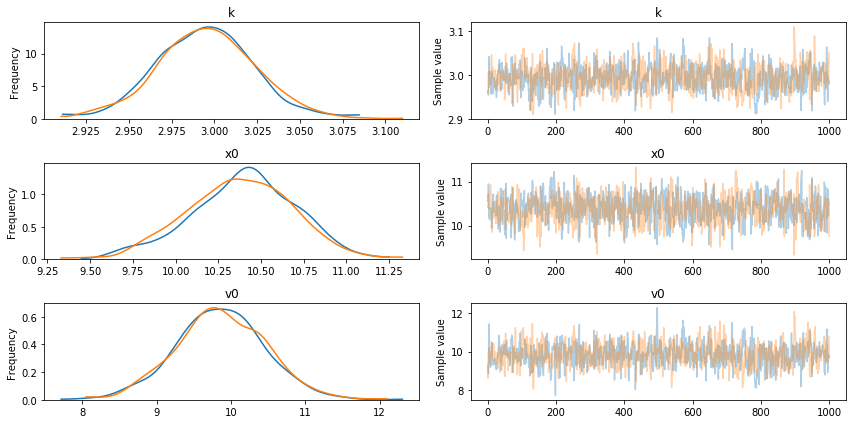

In [34]:
pm.traceplot(trace)

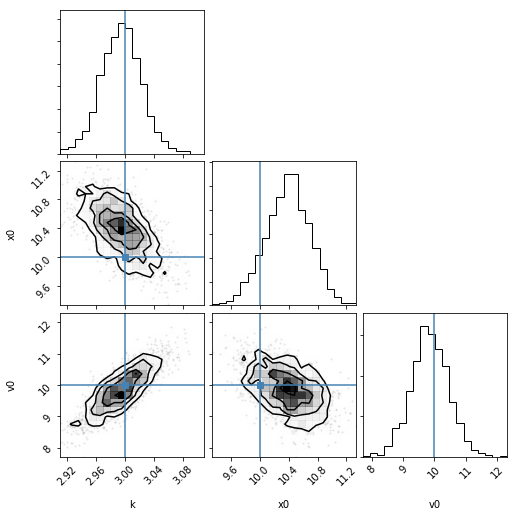

In [22]:
import corner
truth = [k_true, x0_true, v0_true]
samples = np.vstack([trace[k].flatten() for k in ["k", "x0", "v0"]]).T
corner.corner(samples, labels=["k", "x0", "v0"], truths=truth);


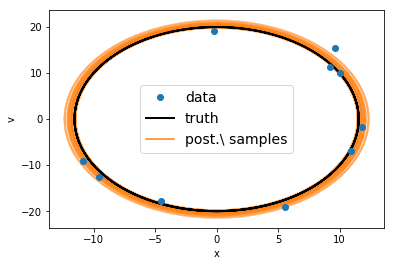

In [63]:
fig, ax = plt.subplots()
ax.plot(x_obs, v_obs, 'o', label='data', zorder=np.inf)


#plt.plot(x, y_obs, ".k", label="observations")

for j in np.random.randint(len(trace), size=25):
    session.run(k_tf.assign(trace[j]['k']))
    session.run(x0_tf.assign(trace[j]['x0']))
    session.run(v0_tf.assign(trace[j]['v0']))
    xval, vval = session.run(pred)
    ax.plot(xval, vval, color="C1", alpha=0.3)

ax.plot(xcompare, vcompare, lw=2, label="truth", color='black')
ax.plot([], [], color="C1", label="post.\ samples")

ax.set_xlabel("x")
ax.set_ylabel('v')


plt.legend(fontsize=14);


time it on evaluating function, evaluating derivative, timing of individual function calls 

In [68]:
trace.get_sampler_stats('depth')

array([3, 3, 4, ..., 3, 3, 4])

In [67]:
trace.stat_names

{'depth',
 'diverging',
 'energy',
 'energy_error',
 'max_energy_error',
 'mean_tree_accept',
 'step_size',
 'step_size_bar',
 'tree_size',
 'tune'}

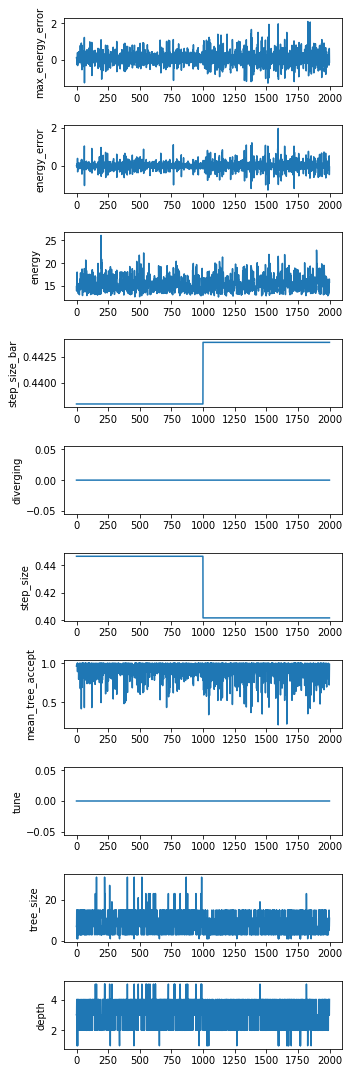

In [80]:
fig, ax = plt.subplots(10, figsize=(5, 15))
ax = ax.flatten()
for name, a in zip(trace.stat_names, ax): 
    a.plot(trace.get_sampler_stats(name))
    a.set_ylabel(name)
plt.tight_layout()
plt.savefig('pymc_statnames.png')

In [95]:
np.sum(2**trace.get_sampler_stats('depth'))

19848

In [96]:
19848. * (58.4e-3 + 150e-3)/3600.

1.1489786666666666

In [21]:
%%timeit
session.run(ll)

43.7 ms ± 989 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%%timeit
session.run(gradients)

120 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


(array([   2.,    0.,    0.,    4.,    0.,    7.,    6.,   10.,    7.,
          14.,   19.,   19.,   37.,   38.,   65.,   90.,  130.,  192.,
         321., 1039.]),
 array([0.2125919 , 0.25196231, 0.29133271, 0.33070312, 0.37007352,
        0.40944393, 0.44881433, 0.48818474, 0.52755514, 0.56692555,
        0.60629595, 0.64566636, 0.68503676, 0.72440717, 0.76377757,
        0.80314798, 0.84251838, 0.88188879, 0.92125919, 0.9606296 ,
        1.        ]),
 <a list of 20 Patch objects>)

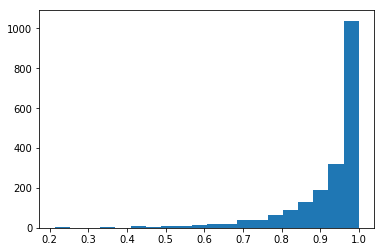

In [83]:
plt.hist(trace.get_sampler_stats('mean_tree_accept'), bins=20)

In [84]:
trace.get_sampler_stats('mean_tree_accept').mean()

0.9223413005628803

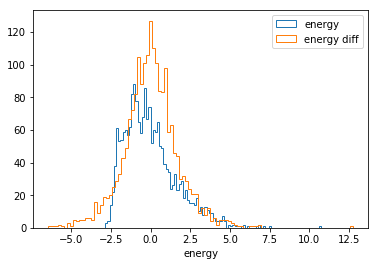

In [88]:
energy = trace['energy']
energy_diff = np.diff(energy)
plt.hist(energy - energy.mean(), label='energy', histtype='step', bins=100)
plt.hist(energy_diff, label='energy diff', histtype='step', bins=100)
plt.legend()
plt.xlabel('energy')
plt.savefig('pymc3energyLevels.png')